In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from box.boxio import generate_integrated_xyxy_list,parse_detections


In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']


In [3]:
def calc_freq(box_list,x_min,y_min,x_max,y_max, split=100):
    # 座標を分割し、グリッドを作成する
    x_grid = np.linspace(x_min, x_max, num=split)
    y_grid = np.linspace(y_min, y_max, num=split)
    x_mesh_grid, y_mesh_grid = np.meshgrid(x_grid, y_grid)

    # 分割した座標に合わせて元の座標を変換する
    x_indices = np.digitize(box_list[:,0], x_grid) - 1
    y_indices = np.digitize(box_list[:,1], y_grid) - 1

    grid_freq = np.zeros((len(y_grid), len(x_grid)), dtype=int)
    for i in range(len(x_indices)):
        grid_freq[y_indices[i], x_indices[i]] += 1
    return grid_freq,x_mesh_grid,y_mesh_grid


In [4]:
def distribution_normalize_detections(det_list,base_box_list,split=100):
    if det_list is not None:
        conf_list = det_list[0].numpy()
        box_list = det_list[1].numpy()

        x_grid_min = min([min(box_list[:,0]),min(base_box_list[:,0])])
        x_grid_max = max([max(box_list[:,0]),max(base_box_list[:,0])])
        y_grid_min = min([min(box_list[:,1]),min(base_box_list[:,1])])
        y_grid_max = max([max(box_list[:,1]),max(base_box_list[:,1])])

        base_freq,_,_ = calc_freq(base_box_list,x_grid_min,y_grid_min,x_grid_max,y_grid_max,split)
        np.place(base_freq,base_freq==0,1)
        freq,x_mesh_grid,y_mesh_grid = calc_freq(box_list,x_grid_min,y_grid_min,x_grid_max,y_grid_max,split)

        # gtの検出で正規化
        normalize_freq = freq
        return normalize_freq, x_mesh_grid, y_mesh_grid
    else:
        normalize_freq = np.zeros((split,split))
        return normalize_freq, None, None


In [5]:
base_path = "../datasets/casia/test_face_moving/detection/"

# det_path_list = ["../dpatch_fix_coordinate/","../markl_fix_coordinate/","../proposed_weighted/"]
det_path_list = ["../dpatch_fix_coordinate/","../markl_fix_coordinate/"]
# ,"../proposed_weighted/"
det_name_list = ["DPatch","MarkL"]
# ,"Proposed"

# prev_det_path = "../outputs/moving_set_det/markL/"
# propose_det_path = "../outputs/moving_set_det/tiling_weited/"
det_labels = ["TP","FN","FP"]
tp_fn_fp_file = ["tp_det.csv", "fn_det.csv", "fp_det.csv"]

tp_fn_fp_path = [[os.path.join(det_path, file) for file in tp_fn_fp_file] for det_path in det_path_list]

# prev_tp_fn_fp_path = [os.path.join(prev_det_path, file) for file in tp_fn_fp_file]
# propose_tp_fn_fp_path = [os.path.join(propose_det_path, file) for file in tp_fn_fp_file]


# 検出を統合したリストの作成
base_conf_list, base_box_list = generate_integrated_xyxy_list(base_path)


base_conf_list = base_conf_list.numpy()
base_box_list = base_box_list.numpy()


In [6]:
# plt.figure()
# heat_vmax = np.max(normalize_freq) if np.max(normalize_freq) > 0 else 1
# plt.imshow(normalize_freq, origin='lower', cmap='hot', vmin=0, vmax=heat_vmax)
# plt.colorbar(label='Frequency')
# plt.xlabel('X Axis')
# plt.ylabel('Y Axis')


In [7]:

# def plot_3d_graph(normalize_freq, x_mesh_grid, y_mesh_grid, det_list):
#         if det_list is None:
#                 return

#         # グリッドポイントの頻度を3Dグラフとしてプロット
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')

#         # 頻度を3Dバーとしてプロット
#         ax.bar3d(x_mesh_grid.flatten(), y_mesh_grid.flatten(), np.zeros_like(normalize_freq).flatten(),
#                 (np.ones_like(normalize_freq)/normalize_freq.shape[1]).flatten(), (np.ones_like(normalize_freq)/normalize_freq.shape[0]).flatten(), normalize_freq.flatten(), shade=True)

#         # 軸ラベルの設定
#         ax.set_xlabel('X Axis')
#         ax.set_ylabel('Y Axis')
#         ax.set_zlabel('Frequency')

#         # グリッドの設定
#         ax.set_xticks(x_mesh_grid.flatten())
#         ax.set_yticks(y_mesh_grid.flatten())

#         # グラフの表示
#         plt.show()


In [8]:
# fig, axs = plt.subplots(2, 3)
# for ax in axs.flatten():
#     heat = ax.imshow(normalize_freq, origin='lower', cmap='hot', vmin=0, vmax=heat_vmax)
#     cf= fig.colorbar(heat, ax=ax)
#     cf.ax.ticklabel_format(style='sci', scilimits=(-3,3))

# plt.tight_layout()
# plt.show()


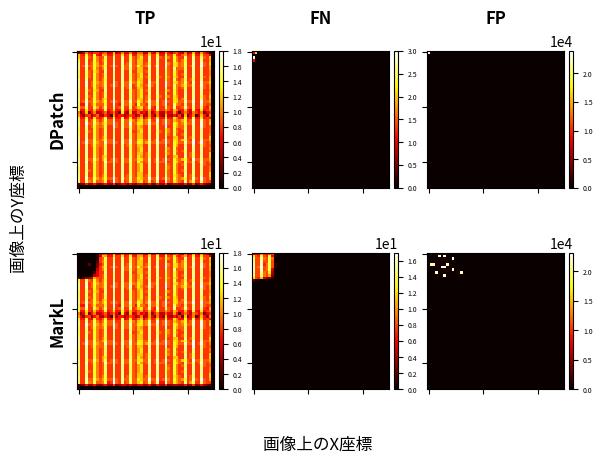

In [9]:

fig, axs = plt.subplots(len(tp_fn_fp_path), 3)
split=50

for i, ax in enumerate(axs.flatten()):
    det_path=tp_fn_fp_path[int(i/3)][i%3]

    det_list = parse_detections(det_path,delimiter=",")

    freq, x_mesh_grid, y_mesh_grid = distribution_normalize_detections(det_list,base_box_list,split=split)
    heat_vmax = np.max(freq) if np.max(freq)!=0 else 1
    heat = ax.imshow(freq, cmap='hot', vmin=0, vmax=heat_vmax,interpolation='none')

    det_class = os.path.basename(det_path).split("_")[0]
    det_class = det_name_list[int(i/3)] + "\n" + det_class

    # ax.set_title(det_class)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = fig.colorbar(heat, cax=cax, orientation='vertical')
    cbar.ax.ticklabel_format(style='sci', scilimits=(-0,0))
    tick_font_size = 5
    cbar.ax.tick_params(labelsize=tick_font_size)

fig.supxlabel('画像上のX座標')
fig.supylabel('画像上のY座標')
# fig.subplots_adjust(wspace=0.1, hspace=0.5)

# 列ごとのラベルを追加
for j, col_label in enumerate(det_labels):
    # 列ラベルを各列の上部に大きく、太字で追加
    ax = axs[0, j]
    ax.annotate(col_label, xy=(0.5, 1.2), xycoords='axes fraction', ha='center', fontsize=12, fontweight='bold')

# 行ごとのラベルを追加
for i, row_label in enumerate(det_name_list):
    axs[i, 0].set_ylabel(row_label, fontsize=12, fontweight='bold')


plt.savefig('moving_det.eps')
plt.show()
